In [1]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

# from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.resnet import resnet26d, resnet50d
from timm.models.registry import register_model

import torch.nn as nn
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        self.act = nn.GELU()
    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = self.norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        return self.act(x)
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
    
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class CBlock(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.conv1 = nn.Conv2d(dim, dim, 1)
        self.conv2 = nn.Conv2d(dim, dim, 1)
        self.attn = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)
#        self.attn = nn.Conv2d(dim, dim, 13, padding=6, groups=dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = CMlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, mask=None):
        if mask is not None:
            x = x + self.drop_path(self.conv2(self.attn(mask * self.conv1(self.norm1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))))
        else:
            x = x + self.drop_path(self.conv2(self.attn(self.conv1(self.norm1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))))
        x = x + self.drop_path(self.mlp(self.norm2(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
        return x
    
class CMlp(nn.Module):
    # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



In [2]:
# Copyright (c) 2022 Alpha-VL
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# MAE: https://github.com/facebookresearch/mae
# --------------------------------------------------------

from functools import partial
import pdb
import torch
import torch.nn as nn


class MaskedAutoencoderConvViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=True):
        super().__init__()
        # --------------------------------------------------------------------------
        # ConvMAE encoder specifics
        self.patch_embed1 = PatchEmbed(
                img_size=img_size[0], patch_size=patch_size[0], in_chans=in_chans, embed_dim=embed_dim[0])
        self.patch_embed2 = PatchEmbed(
                img_size=img_size[1], patch_size=patch_size[1], in_chans=embed_dim[0], embed_dim=embed_dim[1])
        self.patch_embed3 = PatchEmbed(
                img_size=img_size[2], patch_size=patch_size[2], in_chans=embed_dim[1], embed_dim=embed_dim[2])

        self.patch_embed4 = nn.Linear(embed_dim[2], embed_dim[2])
        self.stage1_output_decode = nn.Conv2d(embed_dim[0], embed_dim[2], 4, stride=4)
        self.stage2_output_decode = nn.Conv2d(embed_dim[1], embed_dim[2], 2, stride=2)

        num_patches = self.patch_embed3.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim[2]), requires_grad=False)
        self.blocks1 = nn.ModuleList([
            CBlock(
                dim=embed_dim[0], num_heads=num_heads, mlp_ratio=mlp_ratio[0],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[0])])
        self.blocks2 = nn.ModuleList([
            CBlock(
                dim=embed_dim[1], num_heads=num_heads, mlp_ratio=mlp_ratio[1],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[1])])
        self.blocks3 = nn.ModuleList([
            Block(
                dim=embed_dim[2], num_heads=num_heads, mlp_ratio=mlp_ratio[2],  qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth[2])])
        self.norm = norm_layer(embed_dim[-1])

        # --------------------------------------------------------------------------
        # ConvMAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim[-1], decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio[0], qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, (patch_size[0] * patch_size[1] * patch_size[2])**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed3.num_patches**.5), cls_token=False)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed3.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
#        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed1.patch_size[0]*self.patch_embed2.patch_size[0]*self.patch_embed3.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        #(n, 196, 2048) -> (n, 14, 14, 16, 16, 8)
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N = x.shape[0]
        L = self.patch_embed3.num_patches
#        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
#        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return ids_keep, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        ids_keep, mask, ids_restore = self.random_masking(x, mask_ratio)
        mask_for_patch1 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 16).reshape(-1, 14, 14, 4, 4).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 56, 56).unsqueeze(1)
        mask_for_patch2 = mask.reshape(-1, 14, 14).unsqueeze(-1).repeat(1, 1, 1, 4).reshape(-1, 14, 14, 2, 2).permute(0, 1, 3, 2, 4).reshape(x.shape[0], 28, 28).unsqueeze(1)
        x = self.patch_embed1(x)
        for blk in self.blocks1:
            x = blk(x, 1 - mask_for_patch1)
        stage1_embed = self.stage1_output_decode(x).flatten(2).permute(0, 2, 1)

        x = self.patch_embed2(x)
        for blk in self.blocks2:
            x = blk(x, 1 - mask_for_patch2)
        stage2_embed = self.stage2_output_decode(x).flatten(2).permute(0, 2, 1)
        x = self.patch_embed3(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.patch_embed4(x)
        # add pos embed w/o cls token
        x = x + self.pos_embed
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, x.shape[-1]))
        stage1_embed = torch.gather(stage1_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage1_embed.shape[-1]))
        stage2_embed = torch.gather(stage2_embed, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, stage2_embed.shape[-1]))


        # apply Transformer blocks
        for blk in self.blocks3:
            x = blk(x)
        x = x + stage1_embed + stage2_embed
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)
#         print(x.shape)
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1]  - x.shape[1], 1)
        x_ = torch.cat([x, mask_tokens], dim=1)  # no cls token
        x = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         print(x.shape)
        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        
#         print(op.shape)
#         print(target.shape)
#         if self.norm_pix_loss:
#             mean = target.mean(dim=-1, keepdim=True)
#             var = target.var(dim=-1, keepdim=True)
#             target = (target - mean) / (var + 1.e-6)**.5

#         loss = (pred - target) ** 2
#         loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

#         loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        unpatchified_img = self.unpatchify(pred)
        return loss, pred, unpatchified_img


def convmae_convvit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderConvViT(
        img_size=[224, 56, 28], patch_size=[4, 2, 2], embed_dim=[64, 128, 256], depth=[2, 2, 16], num_heads=8,
        decoder_embed_dim=256, decoder_depth=8, decoder_num_heads=8, in_chans=8,
        mlp_ratio=[4, 4, 4], norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
model = convmae_convvit_base_patch16_dec512d8b()  # decoder: 512 dim, 8 blocks

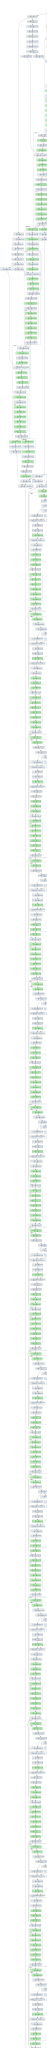

In [3]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,8,224,224), expand_nested=True)
model_graph.visual_graph

In [4]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    with Image.open(path) as f:
        img_array = np.array(f).reshape((125, 125, 8)).astype('float32')
    return img_array

def load_images_from_directory(directory, label):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][:50000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    labels = [label] * len(images)
    return images, labels

# Load images from both directories
X_one, y_one = load_images_from_directory('/home/shashank/dataset/dataset/one/', 0)
X_two, y_two = load_images_from_directory('/home/shashank/dataset/dataset/two/', 1)

# Combine datasets
X = X_one + X_two
Y = y_one + y_two

100%|██████████| 50000/50000 [00:01<00:00, 27035.03it/s] 


In [5]:
# from sklearn.utils import shuffle
# X, Y = shuffle(X, Y, random_state = 42)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):len(X)]
Y_train = Y[:int(len(X)*0.8)]
Y_test = Y[int(len(X)*0.8):len(X)]
Y_train = np.array(Y_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

print(X_train.shape)
print(Y_train.shape)

(80000, 125, 125, 8)
(80000,)


In [6]:
# !pip install matplotlib
X_train/=255.0
X_test/=255.0

In [7]:
!pip install pip install scikit-image

In [8]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = torch.from_numpy(self.x[idx]).moveaxis(2, 0)
        
        if self.transform:
            img = self.transform(img)
            
        sample = {'img' : img}
        
        return sample
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
])

train_dataset = Custom_Dataset(X_train, transform = transform)
test_dataset = Custom_Dataset(X_test, transform = transform)

sample = test_dataset.__getitem__(0)
print((sample['img']).shape)

torch.Size([8, 224, 224])


In [9]:
loss, pred, patches = model(sample['img'].unsqueeze(0), 0.75)
loss

tensor(0.7229, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [10]:
# import numpy as np
# import torch

# # def custom_loss(imgs, pred, mask):

# #     L = 0
# #     for i in range(len(mask)):
# #         l = ((pred[:, : ,i, :] - imgs[:, : ,i, :])**2).unsqueeze(axis = 2).mean(axis = -1)
# #         # Move the mask tensor to the CPU before converting it to a NumPy array
# #         mask_cpu = mask[i].unsqueeze(axis = -1)
# #         loss = (l * mask_cpu).sum()
# #         L+=((loss / mask_cpu.sum()))
    
# #     return L/8
# def bcelogitsloss(output, labels):
#     criterion = nn.BCEWithLogitsLoss(reduction = 'mean')
#     loss = 0
#     output = torch.cat(output, axis = 1)
# #     for i in range(8):
# #         op = output[i].squeeze(1)
# #         print(op.shape)
# #         lab = labels[:, i,:,:].to('cuda')
# #         loss += criterion(op, lab)
#     loss+=criterion(output, labels)
#     return loss

# print(bcelogitsloss(pred, inp))

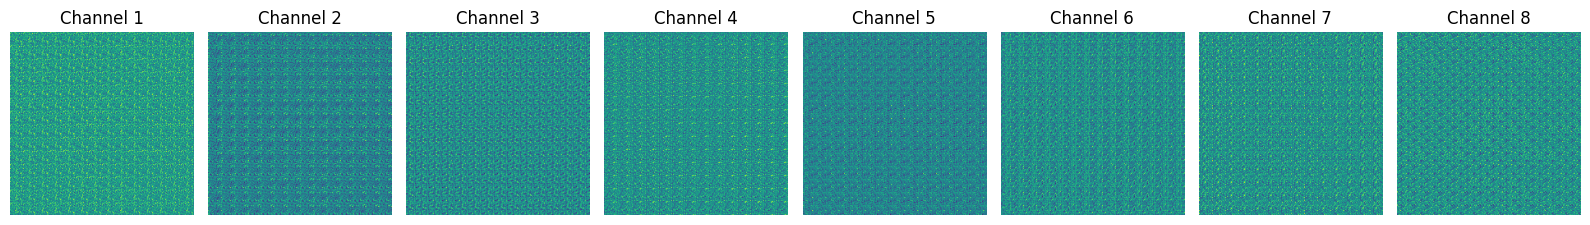

In [11]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

def visualize_prediction(pred):
    # Reshape prediction for visualization
    # preds = pred.reshape((pred.shape[0], 625, 200))

    def unpatchify(x):
        """
        x: (N, L, patch_size**2 * 3)
        imgs: (N, 8, H, W)
        """
        p = 5
        h = w = int(x.shape[1]**0.5)
        assert h * w == x.shape[1]
        
        x = x.reshape((x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape((x.shape[0], 8, h * p, w * p))
        return imgs

    # Unpatchify the prediction
#     preds = unpatchify(pred)[0]
#     preds = torch.cat(pred, axis = 1)
    preds = pred[0]

    # Convert to numpy array and move to CPU if necessary
    img = preds.permute(1, 2, 0).cpu().detach().numpy()

    # Number of channels
    num_channels = img.shape[2]

    # Create a single row of subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(16, 4))

    # Iterate through channels and plot each one in a subplot
    for i in range(num_channels):
        axes[i].imshow(img[:,:,i])  # Adjust colormap as needed
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()
# preds = torch.cat(pred, axis = 1)
# print(preds.shape)
visualize_prediction(patches)

In [12]:
def lr_lambda(epoch):
    warmup_epochs = 3
    decay_rate = 0.8
    if epoch < warmup_epochs:
        # Linear increase during warmup
        return float(epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warmup
        return decay_rate ** (epoch - warmup_epochs + 1)

In [13]:
from sklearn.metrics import roc_auc_score

In [22]:
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []

    model.train()
    scheduler.step()

    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        optimizer.zero_grad()

        loss, outputs, patches = model(image)
        loss.sum().backward()
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        if step%100 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}')

        train_loss.append(loss_reduced.detach().cpu().numpy())
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            loss, outputs, patches = model(image)
            
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            valid_loss.append(loss_reduced.detach().cpu().numpy())
            
            if step%500 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}')
            gc.collect()
    # visualize_prediction(patches)
    return np.mean(train_loss), np.mean(valid_loss)

In [23]:
def data():

    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    ])
    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, transform = transform)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, transform = transform)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=128,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=64,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [ ]:

def train_function(model, epochs, dev):
    lr = 1.5e-4
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 0.005)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = dev
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./conv_mae_model_epoch.pth')

def _mp_fn(rank, flags):
    try:
        model = convmae_convvit_base_patch16_dec512d8b()
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=200, dev = dev)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

num_training_steps = 62500, world_size=4


Epoch 1/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.7195985913276672


Epoch 1/200 (Train): 100batch [07:30,  1.52s/batch]

Train_Batch: 100, loss: 0.023895161226391792


Epoch 1/200 (Train): 156batch [08:47,  3.38s/batch]
Epoch 1/200 (Train): 156batch [08:49,  3.40s/batch]
Epoch 1/200 (Train): 156batch [08:47,  3.38s/batch]
Epoch 1/200 (Train): 156batch [08:47,  3.38s/batch]
Epoch 1/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.02067592926323414


Epoch 1/200 (Train): 78batch [01:01,  1.27batch/s]
Epoch 1/200 (Train): 78batch [01:01,  1.27batch/s]
Epoch 1/200 (Train): 78batch [01:01,  1.27batch/s]
Epoch 1/200 (Train): 78batch [01:01,  1.27batch/s]


Epoch 1/200, Train Loss: 0.0861, Val Loss: 0.0206


Epoch 2/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01926460489630699


Epoch 2/200 (Train): 100batch [02:18,  1.42s/batch]

Train_Batch: 100, loss: 0.017179450020194054


Epoch 2/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 2/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 2/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 2/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 2/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01823691837489605


Epoch 2/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 2/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 2/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 2/200 (Train): 78batch [00:33,  2.31batch/s]


Epoch 2/200, Train Loss: 0.0176, Val Loss: 0.0181


Epoch 3/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01665235310792923


Epoch 3/200 (Train): 100batch [02:20,  1.36s/batch]

Train_Batch: 100, loss: 0.016610469669103622


Epoch 3/200 (Train): 156batch [03:36,  1.39s/batch]
Epoch 3/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 3/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 3/200 (Train): 156batch [03:35,  1.38s/batch]
Epoch 3/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.018604440614581108


Epoch 3/200 (Train): 78batch [00:36,  2.12batch/s]
Epoch 3/200 (Train): 78batch [00:36,  2.12batch/s]
Epoch 3/200 (Train): 78batch [00:36,  2.12batch/s]
Epoch 3/200 (Train): 78batch [00:36,  2.12batch/s]


Epoch 3/200, Train Loss: 0.0210, Val Loss: 0.0185


Epoch 4/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017112750560045242


Epoch 4/200 (Train): 100batch [02:20,  1.39s/batch]

Train_Batch: 100, loss: 0.01652228645980358


Epoch 4/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 4/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 4/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 4/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 4/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017922639846801758


Epoch 4/200 (Train): 78batch [00:30,  2.58batch/s]
Epoch 4/200 (Train): 78batch [00:30,  2.58batch/s]
Epoch 4/200 (Train): 78batch [00:30,  2.58batch/s]
Epoch 4/200 (Train): 78batch [00:30,  2.57batch/s]


Epoch 4/200, Train Loss: 0.0165, Val Loss: 0.0178


Epoch 5/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016304776072502136


Epoch 5/200 (Train): 100batch [02:19,  1.56s/batch]

Train_Batch: 100, loss: 0.016450699418783188


Epoch 5/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 5/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 5/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 5/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 5/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01787802018225193


Epoch 5/200 (Train): 78batch [00:27,  2.89batch/s]
Epoch 5/200 (Train): 78batch [00:27,  2.88batch/s]
Epoch 5/200 (Train): 78batch [00:27,  2.88batch/s]
Epoch 5/200 (Train): 78batch [00:27,  2.88batch/s]


Epoch 5/200, Train Loss: 0.0164, Val Loss: 0.0178


Epoch 6/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016254976391792297


Epoch 6/200 (Train): 100batch [02:29,  1.45s/batch]

Train_Batch: 100, loss: 0.0164177343249321


Epoch 6/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 6/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 6/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 6/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 6/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017855307087302208


Epoch 6/200 (Train): 78batch [00:33,  2.34batch/s]
Epoch 6/200 (Train): 78batch [00:33,  2.34batch/s]
Epoch 6/200 (Train): 78batch [00:33,  2.34batch/s]
Epoch 6/200 (Train): 78batch [00:33,  2.34batch/s]


Epoch 6/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 7/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01622983254492283


Epoch 7/200 (Train): 100batch [02:26,  1.50s/batch]

Train_Batch: 100, loss: 0.016399845480918884


Epoch 7/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 7/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 7/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 7/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 7/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017842188477516174


Epoch 7/200 (Train): 78batch [00:28,  2.73batch/s]
Epoch 7/200 (Train): 78batch [00:28,  2.72batch/s]
Epoch 7/200 (Train): 78batch [00:28,  2.72batch/s]
Epoch 7/200 (Train): 78batch [00:28,  2.72batch/s]


Epoch 7/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 8/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016215413808822632


Epoch 8/200 (Train): 100batch [02:26,  1.51s/batch]

Train_Batch: 100, loss: 0.016388753429055214


Epoch 8/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 8/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 8/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 8/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 8/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01783384382724762


Epoch 8/200 (Train): 78batch [00:36,  2.15batch/s]
Epoch 8/200 (Train): 78batch [00:36,  2.15batch/s]
Epoch 8/200 (Train): 78batch [00:36,  2.15batch/s]
Epoch 8/200 (Train): 78batch [00:36,  2.15batch/s]


Epoch 8/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 9/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016205936670303345


Epoch 9/200 (Train): 100batch [02:25,  1.47s/batch]

Train_Batch: 100, loss: 0.01638268493115902


Epoch 9/200 (Train): 156batch [03:45,  1.44s/batch]
Epoch 9/200 (Train): 156batch [03:43,  1.44s/batch]
Epoch 9/200 (Train): 156batch [03:43,  1.44s/batch]
Epoch 9/200 (Train): 156batch [03:43,  1.44s/batch]
Epoch 9/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017829081043601036


Epoch 9/200 (Train): 78batch [00:34,  2.27batch/s]
Epoch 9/200 (Train): 78batch [00:34,  2.27batch/s]
Epoch 9/200 (Train): 78batch [00:34,  2.27batch/s]
Epoch 9/200 (Train): 78batch [00:34,  2.27batch/s]


Epoch 9/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 10/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016200799494981766


Epoch 10/200 (Train): 100batch [02:19,  1.54s/batch]

Train_Batch: 100, loss: 0.0163780078291893


Epoch 10/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 10/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 10/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 10/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 10/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017825942486524582


Epoch 10/200 (Train): 78batch [00:35,  2.22batch/s]
Epoch 10/200 (Train): 78batch [00:35,  2.22batch/s]
Epoch 10/200 (Train): 78batch [00:35,  2.22batch/s]
Epoch 10/200 (Train): 78batch [00:35,  2.22batch/s]


Epoch 10/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 11/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016197578981518745


Epoch 11/200 (Train): 100batch [02:23,  1.55s/batch]

Train_Batch: 100, loss: 0.01637466996908188


Epoch 11/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 11/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 11/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 11/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 11/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017823994159698486


Epoch 11/200 (Train): 78batch [00:39,  1.95batch/s]
Epoch 11/200 (Train): 78batch [00:39,  1.95batch/s]
Epoch 11/200 (Train): 78batch [00:39,  1.95batch/s]
Epoch 11/200 (Train): 78batch [00:39,  1.95batch/s]


Epoch 11/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 12/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016194608062505722


Epoch 12/200 (Train): 100batch [04:36,  1.58s/batch]

Train_Batch: 100, loss: 0.016373176127672195


Epoch 12/200 (Train): 156batch [05:58,  2.30s/batch]
Epoch 12/200 (Train): 156batch [06:01,  2.31s/batch]
Epoch 12/200 (Train): 156batch [05:58,  2.30s/batch]
Epoch 12/200 (Train): 156batch [05:58,  2.30s/batch]
Epoch 12/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017822574824094772


Epoch 12/200 (Train): 78batch [00:42,  1.84batch/s]
Epoch 12/200 (Train): 78batch [00:42,  1.84batch/s]
Epoch 12/200 (Train): 78batch [00:42,  1.84batch/s]
Epoch 12/200 (Train): 78batch [00:42,  1.85batch/s]


Epoch 12/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 13/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016193486750125885


Epoch 13/200 (Train): 100batch [02:22,  1.35s/batch]

Train_Batch: 100, loss: 0.01637154445052147


Epoch 13/200 (Train): 156batch [03:43,  1.44s/batch]
Epoch 13/200 (Train): 156batch [03:42,  1.43s/batch]
Epoch 13/200 (Train): 156batch [03:42,  1.43s/batch]
Epoch 13/200 (Train): 156batch [03:42,  1.43s/batch]
Epoch 13/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017822273075580597


Epoch 13/200 (Train): 78batch [00:36,  2.14batch/s]
Epoch 13/200 (Train): 78batch [00:36,  2.14batch/s]
Epoch 13/200 (Train): 78batch [00:36,  2.14batch/s]
Epoch 13/200 (Train): 78batch [00:36,  2.14batch/s]


Epoch 13/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 14/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016191639006137848


Epoch 14/200 (Train): 100batch [02:26,  1.32s/batch]

Train_Batch: 100, loss: 0.01637043058872223


Epoch 14/200 (Train): 156batch [03:40,  1.42s/batch]
Epoch 14/200 (Train): 156batch [03:40,  1.42s/batch]
Epoch 14/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 14/200 (Train): 156batch [03:40,  1.42s/batch]
Epoch 14/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017820730805397034


Epoch 14/200 (Train): 78batch [00:34,  2.24batch/s]
Epoch 14/200 (Train): 78batch [00:34,  2.24batch/s]
Epoch 14/200 (Train): 78batch [00:34,  2.24batch/s]
Epoch 14/200 (Train): 78batch [00:34,  2.24batch/s]


Epoch 14/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 15/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016190748661756516


Epoch 15/200 (Train): 100batch [02:28,  1.61s/batch]

Train_Batch: 100, loss: 0.01636965200304985


Epoch 15/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 15/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 15/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 15/200 (Train): 156batch [03:51,  1.48s/batch]
Epoch 15/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781996339559555


Epoch 15/200 (Train): 78batch [00:30,  2.53batch/s]
Epoch 15/200 (Train): 78batch [00:30,  2.53batch/s]
Epoch 15/200 (Train): 78batch [00:30,  2.53batch/s]
Epoch 15/200 (Train): 78batch [00:30,  2.53batch/s]


Epoch 15/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 16/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016190174967050552


Epoch 16/200 (Train): 100batch [02:22,  1.40s/batch]

Train_Batch: 100, loss: 0.01636907085776329


Epoch 16/200 (Train): 156batch [03:35,  1.38s/batch]
Epoch 16/200 (Train): 156batch [03:35,  1.38s/batch]
Epoch 16/200 (Train): 156batch [03:35,  1.38s/batch]
Epoch 16/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 16/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819419503211975


Epoch 16/200 (Train): 78batch [00:30,  2.57batch/s]
Epoch 16/200 (Train): 78batch [00:30,  2.56batch/s]
Epoch 16/200 (Train): 78batch [00:30,  2.56batch/s]
Epoch 16/200 (Train): 78batch [00:30,  2.56batch/s]


Epoch 16/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 17/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189591959118843


Epoch 17/200 (Train): 100batch [02:22,  1.47s/batch]

Train_Batch: 100, loss: 0.01636892557144165


Epoch 17/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 17/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 17/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 17/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 17/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01782052032649517


Epoch 17/200 (Train): 78batch [00:32,  2.39batch/s]
Epoch 17/200 (Train): 78batch [00:32,  2.39batch/s]
Epoch 17/200 (Train): 78batch [00:32,  2.39batch/s]
Epoch 17/200 (Train): 78batch [00:32,  2.38batch/s]


Epoch 17/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 18/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618948206305504


Epoch 18/200 (Train): 100batch [02:26,  1.39s/batch]

Train_Batch: 100, loss: 0.016369419172406197


Epoch 18/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 18/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 18/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 18/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 18/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781967654824257


Epoch 18/200 (Train): 78batch [00:32,  2.36batch/s]
Epoch 18/200 (Train): 78batch [00:32,  2.36batch/s]
Epoch 18/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 18/200 (Train): 78batch [00:32,  2.38batch/s]


Epoch 18/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 19/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618901453912258


Epoch 19/200 (Train): 100batch [02:23,  1.41s/batch]

Train_Batch: 100, loss: 0.016369253396987915


Epoch 19/200 (Train): 156batch [03:45,  1.45s/batch]
Epoch 19/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 19/200 (Train): 156batch [03:45,  1.45s/batch]
Epoch 19/200 (Train): 156batch [03:45,  1.45s/batch]
Epoch 19/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819762229919434


Epoch 19/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 19/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 19/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 19/200 (Train): 78batch [00:33,  2.36batch/s]


Epoch 19/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 20/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016188938170671463


Epoch 20/200 (Train): 100batch [02:26,  1.48s/batch]

Train_Batch: 100, loss: 0.016369448974728584


Epoch 20/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 20/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 20/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 20/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 20/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818961292505264


Epoch 20/200 (Train): 78batch [00:35,  2.18batch/s]
Epoch 20/200 (Train): 78batch [00:35,  2.18batch/s]
Epoch 20/200 (Train): 78batch [00:35,  2.18batch/s]
Epoch 20/200 (Train): 78batch [00:35,  2.17batch/s]
Epoch 21/200 (Train): 0batch [00:00, ?batch/s]

Epoch 20/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 21/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618940569460392


Epoch 21/200 (Train): 100batch [02:21,  1.56s/batch]

Train_Batch: 100, loss: 0.016369439661502838


Epoch 21/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 21/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 21/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 21/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 21/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781943067908287


Epoch 21/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 21/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 21/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 21/200 (Train): 78batch [00:33,  1.80batch/s]

Epoch 21/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 21/200 (Train): 78batch [00:33,  2.34batch/s]
Epoch 22/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189636662602425


Epoch 22/200 (Train): 100batch [02:18,  1.34s/batch]

Train_Batch: 100, loss: 0.01636854000389576


Epoch 22/200 (Train): 156batch [03:34,  1.37s/batch]
Epoch 22/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 22/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 22/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 22/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819631844758987


Epoch 22/200 (Train): 78batch [00:26,  2.91batch/s]
Epoch 22/200 (Train): 78batch [00:26,  2.91batch/s]
Epoch 22/200 (Train): 78batch [00:26,  2.91batch/s]
Epoch 22/200 (Train): 78batch [00:26,  2.91batch/s]


Epoch 22/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 23/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618930697441101


Epoch 23/200 (Train): 100batch [02:24,  1.36s/batch]

Train_Batch: 100, loss: 0.01636865735054016


Epoch 23/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 23/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 23/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 23/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 23/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781965233385563


Epoch 23/200 (Train): 78batch [00:34,  2.23batch/s]
Epoch 23/200 (Train): 78batch [00:34,  2.23batch/s]
Epoch 23/200 (Train): 78batch [00:34,  2.23batch/s]
Epoch 23/200 (Train): 78batch [00:34,  2.23batch/s]


Epoch 23/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 24/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618960127234459


Epoch 24/200 (Train): 100batch [02:26,  1.47s/batch]

Train_Batch: 100, loss: 0.016369204968214035


Epoch 24/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 24/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 24/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 24/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 24/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819605767726898


Epoch 24/200 (Train): 78batch [00:38,  2.02batch/s]
Epoch 24/200 (Train): 78batch [00:38,  2.02batch/s]
Epoch 24/200 (Train): 78batch [00:38,  2.02batch/s]


Epoch 24/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 24/200 (Train): 78batch [00:38,  2.01batch/s]
Epoch 25/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618921384215355


Epoch 25/200 (Train): 100batch [02:23,  1.60s/batch]

Train_Batch: 100, loss: 0.01636911928653717


Epoch 25/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 25/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 25/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 25/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 25/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819272354245186


Epoch 25/200 (Train): 78batch [00:26,  2.93batch/s]
Epoch 25/200 (Train): 78batch [00:26,  2.92batch/s]
Epoch 25/200 (Train): 78batch [00:26,  2.93batch/s]
Epoch 25/200 (Train): 78batch [00:26,  2.93batch/s]


Epoch 25/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 26/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618938520550728


Epoch 26/200 (Train): 100batch [02:17,  1.53s/batch]

Train_Batch: 100, loss: 0.01636877842247486


Epoch 26/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 26/200 (Train): 156batch [03:34,  1.37s/batch]
Epoch 26/200 (Train): 156batch [03:34,  1.37s/batch]
Epoch 26/200 (Train): 156batch [03:34,  1.38s/batch]
Epoch 26/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818842083215714


Epoch 26/200 (Train): 78batch [00:31,  2.51batch/s]
Epoch 26/200 (Train): 78batch [00:31,  2.51batch/s]
Epoch 26/200 (Train): 78batch [00:31,  2.51batch/s]
Epoch 26/200 (Train): 78batch [00:31,  2.50batch/s]


Epoch 26/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 27/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618923433125019


Epoch 27/200 (Train): 100batch [02:26,  1.54s/batch]

Train_Batch: 100, loss: 0.016368968412280083


Epoch 27/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 27/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 27/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 27/200 (Train): 156batch [03:51,  1.49s/batch]
Epoch 27/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819082364439964


Epoch 27/200 (Train): 78batch [00:40,  1.93batch/s]
Epoch 27/200 (Train): 78batch [00:40,  1.92batch/s]
Epoch 27/200 (Train): 78batch [00:40,  1.92batch/s]
Epoch 27/200 (Train): 78batch [00:40,  1.93batch/s]


Epoch 27/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 28/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189804300665855


Epoch 28/200 (Train): 100batch [02:17,  1.32s/batch]

Train_Batch: 100, loss: 0.016369493678212166


Epoch 28/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 28/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 28/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 28/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 28/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781967282295227


Epoch 28/200 (Train): 78batch [00:32,  2.37batch/s]
Epoch 28/200 (Train): 78batch [00:32,  2.37batch/s]
Epoch 28/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 28/200 (Train): 78batch [00:33,  2.35batch/s]
Epoch 29/200 (Train): 0batch [00:00, ?batch/s]

Epoch 28/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 29/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016188904643058777


Epoch 29/200 (Train): 100batch [02:27,  1.49s/batch]

Train_Batch: 100, loss: 0.016369743272662163


Epoch 29/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 29/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 29/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 29/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 29/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017820408567786217


Epoch 29/200 (Train): 78batch [00:26,  2.93batch/s]
Epoch 29/200 (Train): 78batch [00:26,  2.93batch/s]
Epoch 29/200 (Train): 78batch [00:26,  2.93batch/s]
Epoch 29/200 (Train): 78batch [00:26,  2.93batch/s]


Epoch 29/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 30/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189567744731903


Epoch 30/200 (Train): 100batch [02:29,  1.53s/batch]

Train_Batch: 100, loss: 0.016368936747312546


Epoch 30/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 30/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 30/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 30/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 30/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819803208112717


Epoch 30/200 (Train): 78batch [00:37,  2.11batch/s]
Epoch 30/200 (Train): 78batch [00:37,  2.10batch/s]
Epoch 30/200 (Train): 78batch [00:37,  2.10batch/s]
Epoch 30/200 (Train): 78batch [00:37,  2.11batch/s]


Epoch 30/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 31/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189225018024445


Epoch 31/200 (Train): 100batch [02:23,  1.54s/batch]

Train_Batch: 100, loss: 0.01636868342757225


Epoch 31/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 31/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 31/200 (Train): 156batch [03:42,  1.43s/batch]
Epoch 31/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 31/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819197848439217


Epoch 31/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 31/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 31/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 31/200 (Train): 78batch [00:31,  2.48batch/s]


Epoch 31/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 32/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618935354053974


Epoch 32/200 (Train): 100batch [02:27,  1.53s/batch]

Train_Batch: 100, loss: 0.016369076445698738


Epoch 32/200 (Train): 156batch [03:45,  1.44s/batch]
Epoch 32/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 32/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 32/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 32/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819726839661598


Epoch 32/200 (Train): 78batch [00:35,  2.19batch/s]
Epoch 32/200 (Train): 78batch [00:35,  2.19batch/s]
Epoch 32/200 (Train): 78batch [00:35,  2.19batch/s]
Epoch 32/200 (Train): 78batch [00:35,  2.18batch/s]


Epoch 32/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 33/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189374029636383


Epoch 33/200 (Train): 100batch [02:23,  1.40s/batch]

Train_Batch: 100, loss: 0.016368797048926353


Epoch 33/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 33/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 33/200 (Train): 156batch [03:39,  1.40s/batch]
Epoch 33/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 33/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818724736571312


Epoch 33/200 (Train): 78batch [00:35,  2.20batch/s]
Epoch 33/200 (Train): 78batch [00:35,  2.20batch/s]
Epoch 33/200 (Train): 78batch [00:35,  2.20batch/s]
Epoch 33/200 (Train): 78batch [00:35,  2.20batch/s]


Epoch 33/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 34/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.0161893330514431


Epoch 34/200 (Train): 100batch [02:20,  1.37s/batch]

Train_Batch: 100, loss: 0.01636866293847561


Epoch 34/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 34/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 34/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 34/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 34/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819784581661224


Epoch 34/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 34/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 34/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 34/200 (Train): 78batch [00:31,  2.49batch/s]


Epoch 34/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 35/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618938148021698


Epoch 35/200 (Train): 100batch [02:21,  1.37s/batch]

Train_Batch: 100, loss: 0.016369346529245377


Epoch 35/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 35/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 35/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 35/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 35/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819005995988846


Epoch 35/200 (Train): 78batch [00:32,  2.39batch/s]
Epoch 35/200 (Train): 78batch [00:32,  2.38batch/s]
Epoch 35/200 (Train): 78batch [00:32,  2.40batch/s]
Epoch 35/200 (Train): 78batch [00:32,  2.37batch/s]
Epoch 36/200 (Train): 0batch [00:00, ?batch/s]

Epoch 35/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 36/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189580783247948


Epoch 36/200 (Train): 100batch [02:23,  1.38s/batch]

Train_Batch: 100, loss: 0.01636885292828083


Epoch 36/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 36/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 36/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 36/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 36/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819974571466446


Epoch 36/200 (Train): 78batch [00:28,  2.76batch/s]
Epoch 36/200 (Train): 78batch [00:28,  2.76batch/s]
Epoch 36/200 (Train): 78batch [00:28,  2.76batch/s]
Epoch 36/200 (Train): 78batch [00:28,  2.78batch/s]


Epoch 36/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 37/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.0161892157047987


Epoch 37/200 (Train): 100batch [02:20,  1.45s/batch]

Train_Batch: 100, loss: 0.016368763521313667


Epoch 37/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 37/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 37/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 37/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 37/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819516360759735


Epoch 37/200 (Train): 78batch [00:31,  2.44batch/s]
Epoch 37/200 (Train): 78batch [00:31,  2.44batch/s]
Epoch 37/200 (Train): 78batch [00:31,  2.45batch/s]
Epoch 37/200 (Train): 78batch [00:32,  2.43batch/s]


Epoch 37/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 38/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016188928857445717


Epoch 38/200 (Train): 100batch [02:24,  1.36s/batch]

Train_Batch: 100, loss: 0.016369367018342018


Epoch 38/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 38/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 38/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 38/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 38/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819494009017944


Epoch 38/200 (Train): 78batch [00:33,  2.30batch/s]
Epoch 38/200 (Train): 78batch [00:33,  2.30batch/s]
Epoch 38/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 38/200 (Train): 78batch [00:33,  2.30batch/s]


Epoch 38/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 39/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618940383195877


Epoch 39/200 (Train): 100batch [02:27,  1.35s/batch]

Train_Batch: 100, loss: 0.016369055956602097


Epoch 39/200 (Train): 156batch [03:45,  1.45s/batch]
Epoch 39/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 39/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 39/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 39/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819097265601158


Epoch 40/200 (Train): 100batch [02:28,  1.41s/batch]

Train_Batch: 100, loss: 0.016368864104151726


Epoch 40/200 (Train): 156batch [05:35,  2.15s/batch]
Epoch 40/200 (Train): 156batch [05:33,  2.14s/batch]
Epoch 40/200 (Train): 156batch [05:33,  2.14s/batch]
Epoch 40/200 (Train): 156batch [05:33,  2.14s/batch]
Epoch 40/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819754779338837


Epoch 40/200 (Train): 78batch [00:33,  2.32batch/s]
Epoch 40/200 (Train): 78batch [00:33,  2.32batch/s]
Epoch 40/200 (Train): 78batch [00:33,  2.33batch/s]
Epoch 40/200 (Train): 78batch [00:33,  2.30batch/s]


Epoch 40/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 41/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618930697441101


Epoch 41/200 (Train): 100batch [02:22,  1.35s/batch]

Train_Batch: 100, loss: 0.016369322314858437


Epoch 41/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 41/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 41/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 41/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 41/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818741500377655


Epoch 41/200 (Train): 78batch [00:37,  2.07batch/s]
Epoch 41/200 (Train): 78batch [00:37,  2.06batch/s]
Epoch 41/200 (Train): 78batch [00:37,  2.06batch/s]
Epoch 41/200 (Train): 78batch [00:37,  2.06batch/s]


Epoch 41/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 42/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189491376280785


Epoch 42/200 (Train): 100batch [02:23,  1.40s/batch]

Train_Batch: 100, loss: 0.016368791460990906


Epoch 42/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 42/200 (Train): 156batch [03:36,  1.39s/batch]
Epoch 42/200 (Train): 156batch [03:36,  1.39s/batch]
Epoch 42/200 (Train): 156batch [03:36,  1.39s/batch]
Epoch 42/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819197848439217


Epoch 42/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 42/200 (Train): 78batch [00:32,  2.36batch/s]
Epoch 42/200 (Train): 78batch [00:33,  2.36batch/s]
Epoch 42/200 (Train): 78batch [00:33,  2.35batch/s]


Epoch 42/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 43/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189640387892723


Epoch 43/200 (Train): 78batch [01:52,  1.48s/batch]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 44/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 44/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 44/200 (Train): 156batch [03:45,  1.44s/batch]
Epoch 44/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 44/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819387838244438


Epoch 44/200 (Train): 78batch [00:32,  2.40batch/s]
Epoch 44/200 (Train): 78batch [00:32,  2.40batch/s]
Epoch 44/200 (Train): 78batch [00:32,  2.41batch/s]
Epoch 44/200 (Train): 78batch [00:32,  2.39batch/s]


Epoch 44/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 45/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189301386475563


Epoch 45/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 45/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 45/200 (Train): 156batch [03:45,  1.45s/batch]
Epoch 45/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 45/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819063737988472


Epoch 45/200 (Train): 78batch [00:29,  2.68batch/s]
Epoch 45/200 (Train): 78batch [00:29,  2.68batch/s]
Epoch 45/200 (Train): 78batch [00:29,  2.68batch/s]
Epoch 45/200 (Train): 78batch [00:29,  2.68batch/s]


Epoch 45/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 46/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189776360988617


Epoch 46/200 (Train): 100batch [02:29,  1.44s/batch]

Train_Batch: 100, loss: 0.0163688063621521


Epoch 46/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 46/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 46/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 46/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 46/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819425091147423


Epoch 46/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 46/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 46/200 (Train): 78batch [00:31,  2.48batch/s]
Epoch 46/200 (Train): 78batch [00:31,  2.49batch/s]


Epoch 46/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 47/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189422458410263


Epoch 47/200 (Train): 100batch [02:23,  1.34s/batch]

Train_Batch: 100, loss: 0.016369005665183067


Epoch 47/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 47/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 47/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 47/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 47/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781914383172989


Epoch 47/200 (Train): 78batch [00:29,  2.65batch/s]
Epoch 47/200 (Train): 78batch [00:29,  2.65batch/s]
Epoch 47/200 (Train): 78batch [00:29,  2.65batch/s]
Epoch 47/200 (Train): 78batch [00:29,  2.66batch/s]


Epoch 47/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 48/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016188662499189377


Epoch 48/200 (Train): 100batch [02:24,  1.43s/batch]

Train_Batch: 100, loss: 0.01636929251253605


Epoch 48/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 48/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 48/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 48/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 48/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819246277213097


Epoch 48/200 (Train): 10batch [00:03,  2.85batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 49/200 (Train): 100batch [02:31,  1.45s/batch]

Train_Batch: 100, loss: 0.01636917144060135


Epoch 49/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 49/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 49/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 49/200 (Train): 156batch [03:48,  1.46s/batch]
Epoch 49/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818942666053772


Epoch 49/200 (Train): 78batch [00:27,  2.84batch/s]
Epoch 49/200 (Train): 78batch [00:27,  2.84batch/s]
Epoch 49/200 (Train): 78batch [00:27,  2.84batch/s]
Epoch 49/200 (Train): 78batch [00:27,  2.84batch/s]


Epoch 49/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 50/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189463436603546


Epoch 50/200 (Train): 100batch [02:24,  1.35s/batch]

Train_Batch: 100, loss: 0.016369426622986794


Epoch 50/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 50/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 50/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 50/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 50/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818687483668327


Epoch 50/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 50/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 50/200 (Train): 78batch [00:33,  2.31batch/s]
Epoch 50/200 (Train): 78batch [00:33,  2.31batch/s]


Epoch 50/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 51/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189446672797203


Epoch 51/200 (Train): 100batch [02:30,  1.50s/batch]

Train_Batch: 100, loss: 0.01636858843266964


Epoch 51/200 (Train): 156batch [03:47,  1.46s/batch]
Epoch 51/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 51/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 51/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 51/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781923696398735


Epoch 51/200 (Train): 78batch [00:27,  2.81batch/s]
Epoch 51/200 (Train): 78batch [00:27,  2.81batch/s]
Epoch 51/200 (Train): 78batch [00:27,  2.81batch/s]
Epoch 51/200 (Train): 78batch [00:27,  2.81batch/s]


Epoch 51/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 52/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189096495509148


Epoch 52/200 (Train): 100batch [02:26,  1.37s/batch]

Train_Batch: 100, loss: 0.016368946060538292


Epoch 52/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 52/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 52/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 52/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 52/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819227650761604


Epoch 53/200 (Train): 100batch [02:23,  1.34s/batch]

Train_Batch: 100, loss: 0.016368672251701355


Epoch 53/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 53/200 (Train): 156batch [03:37,  1.39s/batch]
Epoch 53/200 (Train): 156batch [03:39,  1.41s/batch]
Epoch 53/200 (Train): 156batch [03:37,  1.40s/batch]
Epoch 53/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819620668888092


Epoch 53/200 (Train): 78batch [00:27,  2.82batch/s]
Epoch 53/200 (Train): 78batch [00:27,  2.82batch/s]
Epoch 53/200 (Train): 78batch [00:27,  2.82batch/s]
Epoch 53/200 (Train): 78batch [00:27,  2.81batch/s]


Epoch 53/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 54/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189368441700935


Epoch 54/200 (Train): 100batch [02:24,  1.36s/batch]

Train_Batch: 100, loss: 0.01636859029531479


Epoch 54/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 54/200 (Train): 156batch [03:45,  1.44s/batch]
Epoch 54/200 (Train): 156batch [03:43,  1.43s/batch]
Epoch 54/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 54/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01782020553946495


Epoch 54/200 (Train): 78batch [00:27,  2.80batch/s]
Epoch 54/200 (Train): 78batch [00:27,  2.81batch/s]
Epoch 54/200 (Train): 78batch [00:27,  2.82batch/s]
Epoch 54/200 (Train): 78batch [00:27,  2.80batch/s]


Epoch 54/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 55/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618904247879982


Epoch 55/200 (Train): 100batch [02:24,  1.35s/batch]

Train_Batch: 100, loss: 0.016369378194212914


Epoch 55/200 (Train): 156batch [03:44,  1.44s/batch]
Epoch 55/200 (Train): 156batch [03:42,  1.42s/batch]
Epoch 55/200 (Train): 156batch [03:42,  1.43s/batch]
Epoch 55/200 (Train): 156batch [03:41,  1.42s/batch]
Epoch 55/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017818819731473923


Epoch 55/200 (Train): 78batch [00:28,  2.70batch/s]
Epoch 55/200 (Train): 78batch [00:28,  2.71batch/s]
Epoch 55/200 (Train): 78batch [00:28,  2.70batch/s]
Epoch 55/200 (Train): 78batch [00:28,  2.70batch/s]


Epoch 55/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 56/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618974469602108


Epoch 56/200 (Train): 93batch [02:15,  1.51s/batch]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 113/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016188565641641617


Epoch 113/200 (Train): 100batch [02:31,  1.38s/batch]

Train_Batch: 100, loss: 0.01636863872408867


Epoch 113/200 (Train): 156batch [03:51,  1.49s/batch]
Epoch 113/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 113/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 113/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 113/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819490283727646


Epoch 113/200 (Train): 78batch [00:36,  2.16batch/s]
Epoch 113/200 (Train): 78batch [00:36,  2.16batch/s]
Epoch 113/200 (Train): 78batch [00:36,  2.16batch/s]
Epoch 113/200 (Train): 78batch [00:36,  2.16batch/s]


Epoch 113/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 114/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189193353056908


Epoch 114/200 (Train): 100batch [02:26,  1.56s/batch]

Train_Batch: 100, loss: 0.01636924035847187


Epoch 114/200 (Train): 156batch [03:50,  1.48s/batch]
Epoch 114/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 114/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 114/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 114/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01781896874308586


Epoch 114/200 (Train): 78batch [00:41,  1.89batch/s]
Epoch 114/200 (Train): 78batch [00:41,  1.89batch/s]
Epoch 114/200 (Train): 78batch [00:41,  1.90batch/s]
Epoch 114/200 (Train): 78batch [00:41,  1.89batch/s]


Epoch 114/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 115/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618899777531624


Epoch 115/200 (Train): 100batch [02:26,  1.41s/batch]

Train_Batch: 100, loss: 0.016368888318538666


Epoch 115/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 115/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 115/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 115/200 (Train): 156batch [03:46,  1.45s/batch]
Epoch 115/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01782076805830002


Epoch 115/200 (Train): 78batch [00:31,  2.44batch/s]
Epoch 115/200 (Train): 78batch [00:31,  2.44batch/s]
Epoch 115/200 (Train): 78batch [00:31,  2.44batch/s]
Epoch 115/200 (Train): 78batch [00:31,  2.45batch/s]


Epoch 115/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 116/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189251095056534


Epoch 116/200 (Train): 24batch [00:41,  1.55s/batch]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 168/200 (Train): 100batch [02:25,  1.45s/batch]

Train_Batch: 100, loss: 0.01636878028512001


Epoch 168/200 (Train): 156batch [03:49,  1.47s/batch]
Epoch 168/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 168/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 168/200 (Train): 156batch [03:48,  1.47s/batch]
Epoch 168/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819207161664963


Epoch 168/200 (Train): 78batch [00:39,  1.99batch/s]
Epoch 168/200 (Train): 78batch [00:39,  1.99batch/s]
Epoch 168/200 (Train): 78batch [00:39,  1.99batch/s]
Epoch 168/200 (Train): 78batch [00:39,  1.99batch/s]


Epoch 168/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 169/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.016189225018024445


Epoch 169/200 (Train): 100batch [02:24,  1.53s/batch]

Train_Batch: 100, loss: 0.016368579119443893


Epoch 169/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 169/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 169/200 (Train): 156batch [03:40,  1.41s/batch]
Epoch 169/200 (Train): 156batch [03:38,  1.40s/batch]
Epoch 169/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.017819765955209732


Epoch 169/200 (Train): 78batch [00:31,  2.45batch/s]
Epoch 169/200 (Train): 78batch [00:31,  2.45batch/s]
Epoch 169/200 (Train): 78batch [00:31,  2.45batch/s]
Epoch 169/200 (Train): 78batch [00:31,  2.45batch/s]


Epoch 169/200, Train Loss: 0.0163, Val Loss: 0.0177


Epoch 170/200 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.01618931256234646


Epoch 170/200 (Train): 67batch [01:40,  1.32s/batch]

In [ ]:
print('hello')